# LigthGBM

In [1]:
import pandas as pd
from tsm.evaluators import k_fold_validator
from sklearn.metrics import mean_squared_error
from math import sqrt
import joblib
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt

In [4]:
SEED = 42
ROUNDS = 25000
EARLY_STOP = 10
V_ROUNDS = 1000

In [5]:
METER = 2

### Preparing Data

In [6]:
data = pd.read_pickle('data/prep/train_meter_{}.pkl'.format(METER))

In [7]:
exclude = ['timestamp', 'day_suspicious', 'month_suspicious']
y_col = ['log_meter_reading']
x_cols = [x for x in list(data) if x not in exclude + y_col]

### Model Training

In [11]:
lgb_reg_params = {'objective':'regression',  'boosting_type':'gbdt', 'metric':'rmse',
                  'n_jobs':-1, 'learning_rate':0.05, 'max_depth':-1,
                  'tree_learner':'serial', 'colsample_bytree': 0.7, 'subsample_freq': 1,
                  'subsample':0.5, 'max_bin': 255, 'verbose': 0, 'seed': SEED}
                  # 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}

In [ ]:
%%time
for tr_idx, ts_idx in k_fold_validator(k=8, data=data.index.values, shuffle=True, random_state=42):
    
    x = data[x_cols].values
    y = data[y_col].values
    x_tr, x_ts, y_tr, y_ts = x[tr_idx], x[ts_idx], y[tr_idx], y[ts_idx]
    
    lgb_train = lgb.Dataset(x_tr, y_tr.ravel())
    lgb_eval = lgb.Dataset(x_ts, y_ts.ravel())
    lgb_reg = lgb.train(lgb_reg_params, lgb_train, valid_sets=(lgb_train, lgb_eval),
        num_boost_round=ROUNDS,early_stopping_rounds=EARLY_STOP,verbose_eval=V_ROUNDS)
    break

Training until validation scores don't improve for 10 rounds


### Saving Model

In [93]:
rmsle = 0.613134
lgb_reg.save_model('data/models/met{}_lgb_noS_rmsle_{}.pkl'.format(METER, round(rmsle, 3)), num_iteration=lgb_reg.best_iteration)

### Error Analysis

In [94]:
%%time
data['y_hat'] = lgb_reg.predict(data[x_cols].values, num_iteration=lgb_reg.best_iteration)

CPU times: user 1h 9min 1s, sys: 5.64 s, total: 1h 9min 6s
Wall time: 4min 29s


In [95]:
data['errors'] = abs(data.log_meter_reading - data.y_hat)

In [96]:
data.groupby('building_id')['errors'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
building_id,,,,,,,,
209,8781.0,0.110800,0.198953,1.581591e-05,0.037101,0.079559,0.146019,7.210567
885,8776.0,0.112563,0.091425,4.977542e-07,0.044155,0.092546,0.158055,1.357070
203,8781.0,0.113903,0.098087,4.461097e-05,0.042632,0.090914,0.157922,1.115283
1409,7326.0,0.118936,0.090042,3.939134e-06,0.048007,0.102710,0.169854,1.262048
966,8768.0,0.121390,0.191625,1.087794e-05,0.037995,0.081808,0.149502,6.478845
...,...,...,...,...,...,...,...,...
1273,8194.0,0.892668,0.903875,1.470405e-04,0.271922,0.593020,1.223533,6.674511
1235,8784.0,0.895934,1.141500,3.222591e-05,0.165598,0.426783,1.156702,8.345461
1319,8784.0,0.944785,0.818357,1.965285e-05,0.335789,0.723618,1.321083,5.967142


In [108]:
BID = 1235
bid_data = data[data.building_id == BID].reset_index(drop=True)

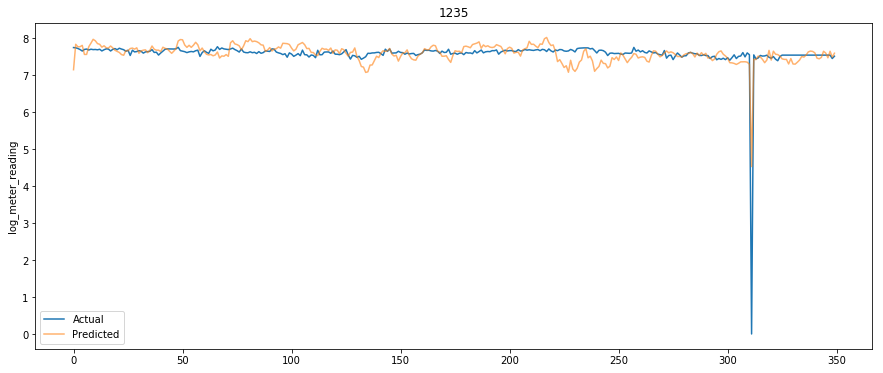

In [114]:
plt.figure(figsize=(15,6))
plt.title(BID)
plt.ylabel('log_meter_reading')
plt.plot(bid_data.log_meter_reading[:350], label='Actual')
plt.plot(bid_data.y_hat[:350], label='Predicted', alpha=0.6)
plt.legend()
plt.show()

In [74]:
original_data = pd.read_pickle('data/prep/train_meter_{}.pkl'.format(METER))

In [83]:
or_bid_data = original_data[original_data.building_id == BID].reset_index(drop=True)

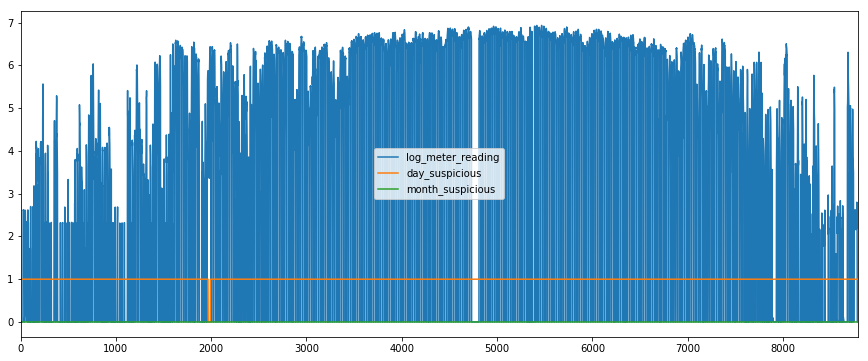

In [84]:
or_bid_data[['log_meter_reading', 'day_suspicious', 'month_suspicious']].plot(figsize=(15,6))